# Randomized Optimization Algorithms

## Introduction

In the previous assignment we analyzed various supervised algorithms, which were all solving some optimization problem in the form of minimizing the derivative of the error. What if the derivative does not exist, like in discrete problems which are not defined on continuous functions? Since discrete functions cannot be differentiated, then the gradient descent tool cannot be used.
Here we turn towards search and various ways of optimizing it, using randomized optimization algorithms. 

## Finding weights for ANN

In this section I will use optimization algorithms to search for the best weights in the Neural Network classification on the problem of Higgs detection from the previous assignment.

Quick review:

   - given outcomes of particle decays, detect Higgs boson; 
   
   - most of the supervised algorithms gave acceptable accuracy ranging from 0.8 - 0.9;
   
   - neural network gave the worst accuracy of around 0.5 (50%) across all experiments with tuning parameters;
    
Since backpropagation algorithm in the neural network did not provide satisfactory accuracy on the Higgs dataset, the problem in Higgs detection becomes a great candidate to apply randomized optimization algorithms weights learning.

From the previous assignment it was concluded that dataset size of 20k records will suffice the experiment, while saving running time significantly.

In [1]:
%matplotlib inline

In [2]:
from algo_evaluation.datasets import *
from algo_evaluation.supervised import neural_network as nn

In [3]:
higgs_data = load_higgs_train(sample_size=20000, verbose=True)

Size of the dataset: 5477
Number of features: 13
Number of positives (signal): 2525
Number of negatives (background): 2952


Learning weights for the neural network will be achieved using pybrain library (same as in the previous assignment which should give a fair comparison). 

The __cost function__ here (called evaluator) will be __MSE__ (mean squared error) and the goal is to minimize it using three different optimization algorithms: RandomizedHillClimber, Genetic Algorithm and Simulated Annealing. 

__Fitness function__ would required maximization of __-MSE__

__Accuracy Comparison across algorithms for Higgs Dataset__

In [4]:
df_nn = nn.compare_weight_learning_optimized(higgs_data)

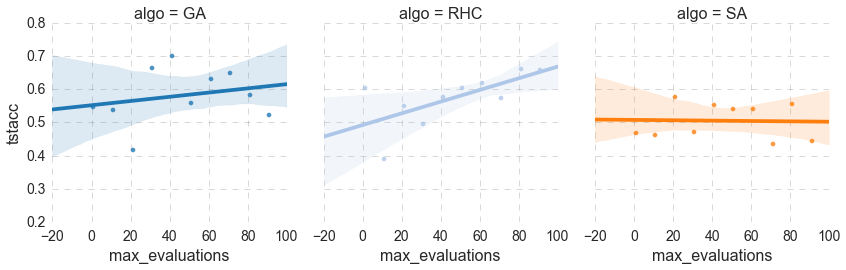

In [8]:
nn.plot_weight_learning_accuracy(df_nn)

Overall, comparing to Backpropagation algorithm, learning weights by means of randomized optimization algorithms performed __significantly__ better (every single algorithm beat the baseline from the previous analysis)
I fitted the regression line through the accuracy points to be able to see the trends easier since algorithms did not reach stability due to limited number of iterations.

Genetic Algorithm gave the highest accuracy reaching 0.8 as compared to maximum of 0.5 using Backpropagation algorithm. Accuracy trending for both, Genetic Algorithm and Hill Climber, is upwords which shows that they kept improving at each iteration. In contrast, variance of the accuracy for Simulated Annealing is quite high (shaded areas around the trending line) which demonstrated the nature of the algorithm as it accepts worse solutions when some conditions apply. In theory, if I were to let it run for more iterations, it might give better results, however for the purpose of contrasting performance of algorithms for Higgs dataset, a constant number of iterations is desirable.

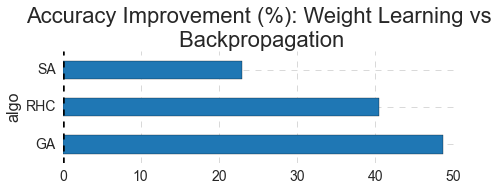

In [18]:
nn.plot_improvement(df_nn, baseline=0.470792365529)

All three algorithms gave an improvement in accuracy when compared to back-propagation algorithm (best = GA (~60%))

__Training and Prediction Time comparison across algorithms for Higgs Dataset__

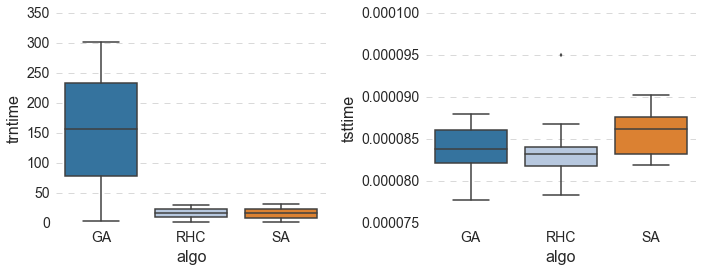

In [6]:
nn.plot_weight_learning_time(df_nn)

Genetic Algorithm gave the best accuracy score, however it took the longest time to learn the weights for the neural network since generating new offspring can be costly as compared to simpler function evaluations for hill climber and simulated annealing.

For visualizing the prediction time for observations (outcomes of particle collisions), I used the average time per record as opposed to prediction time for all records (since total prediction time could be out-weighted by the number of observations.)
Thus, prediction times across all algorithms are comparable as expected, because once the weights have been learned, there is no dependence on the algorithm anymore.

## Optimization Problem 1: Searching for Waldo with "Where is Waldo?" book series

I only recently came across the Waldo-spotting book series (since I grew up outside of the US) through the blog post of Randy Olson where he demonstrated optimal search using genetic algorithm. This problem fascinated me by being both fun and illuminating and here I tried to reproduce some of his results using different randomized optimization algorithms.

Problem is approached as a Traveling Salesman Problem - every possible location of where Waldo could be is checked without backtracking. Density visualization of Waldo locations based on the 7 books already shows some trends - Waldo is most often found in the lower left corner and upper right. 

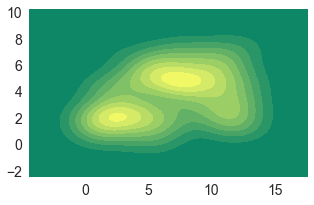

In [19]:
waldo_df = load_waldo_dataset(display=True)

__Fitness Function__: maximize the negative value of the shortest path
(or minimize the dual cost function - minimize the distance between what Waldo-looking solutions covers and the real Waldo coordinates).

In [10]:
from algo_evaluation.optimization.problems import waldo_optimization as wo
from algo_evaluation.optimization.problems import plot_optimal_values as plt

In [23]:
rhc_df, sa_df, ga_df, mm_df = wo.compare_all(waldo_df)

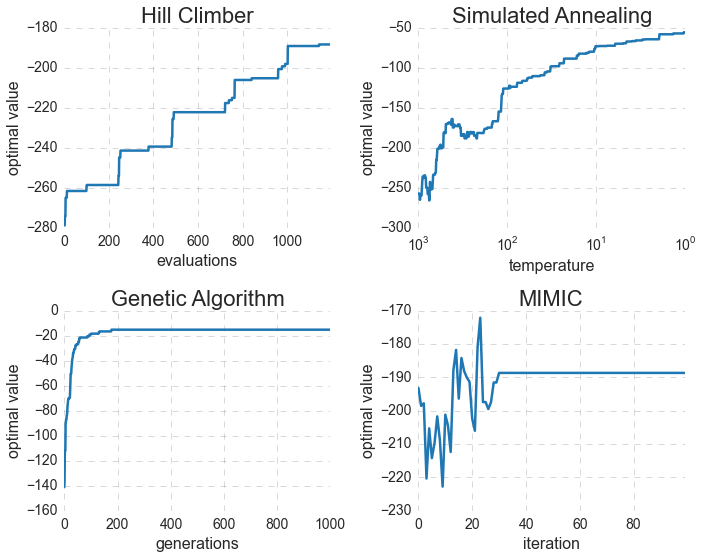

In [25]:
plt.plot_optimal_values(rhc_df, sa_df, ga_df, mm_df)

Each algorithm demonstrated different behavior specific to the nature of the algorithm.

__Hill Climber__ has very clear equilibria islands during which optimal value was remaining the same. The experiments were executed with fixed iterations so Hill Climber did not converge within defined limit.

__Simulated annealing__ was having a hard time finding the optimal path at the beginning since it was allowed to accept worse solutions for high temperatures. Notice, that as temperatures cooled down (I have used the log scale for temperatures on x axis to demonstrate more clearly the fact that algorithm stabilized for low temperatures), worse solutions were not accepted any more and algorithm behaved more like RHC.

__Genetic algorithm__ again outperformed the rest of the algorithms since it continuously tinkers with the solution by slightly mutating the existing best solution until no better solution can be found. Note, that it took a relatively small number of generations to find the optimal path, and the improvement in the solution was very rapid (very steep curve).

__MIMIC__ took smallest number of iterations to converge, however it did not find the best solution. Note, number of iterations for MIMIC as compared to the rest of the algorithms is lower, however this does not mean MIMIC is faster, on a contrary this has shown to be the slowest of all algorithms on the optimization problems that I have selected.

## Optimization Problem 2: Automatic Algorithm Configuration

Finding the best fitting classifier for datasets remains an art to be mastered with years of experience. I recently read the paper from the 13th PYTHON IN SCIENCE CONF. (SCIPY 2014) and was thrilled to learn about an ongoing effort developing hyperopt library, which treats the choice of the classifier and pre-processing modules as an optimization problem.  

I have used the idea from that paper to create a mini-optimization problem for the Decision Tree classifier and, fortunately, I have a perfect baseline from my previous analysis.
I made the classifier constant while optimizing the parameters fed to the classifier. Naturally, this problem can be extended for varied classifier, however for current example it will suffice.

In [11]:
from algo_evaluation.optimization.problems import hyper_optimization as ho

In [12]:
smaller_higgs_data = load_higgs_train(sample_size=2000)

Size of the dataset: 533
Number of features: 13
Number of positives (signal): 235
Number of negatives (background): 298


In [13]:
baseline_accuracy = ho.baseline_dt(smaller_higgs_data)
print 'Decision Tree baseline accuracy (prior to optimizing parameters):', baseline_accuracy

Decision Tree baseline accuracy (prior to optimizing parameters): 0.731865828092


With this optimization problem, I am searching for the best classifier parameters available for tuning (for example, minimum number of samples required to split an internal node and the maximum depth of the tree)

__Fitness Function__: Maximize classifier accuracy score. 

In [14]:
rhc_2_df, sa_2_df, ga_2_df, mm_2_df = ho.compare_all(smaller_higgs_data)

A very interesting outcome arises based on the plots for finding the best solution (outcome was slightly different per experiment based on which solution was chosen first) __Hill Climber__ again found the local optimum and remained in that space for all iteration. It does not mean however that Hill Climber will always demonstrate this behavior for this specific problem - the behavior depends on the initial solution which was generated randomly. __Simulated Annealing__ and __MIMIC__ couldn't settle on the solution as you can see from the jittery graph.
The most interesting behavior is demonstrated by the __Genetic algorithm__ - it found the global optimum (accuracy = 78%) from the very first generation and then remained there through generations without degrading (contrary to MIMIC which at some point did hit desired maximum however it quickly deviated from toward in favor of less optimal solutions)

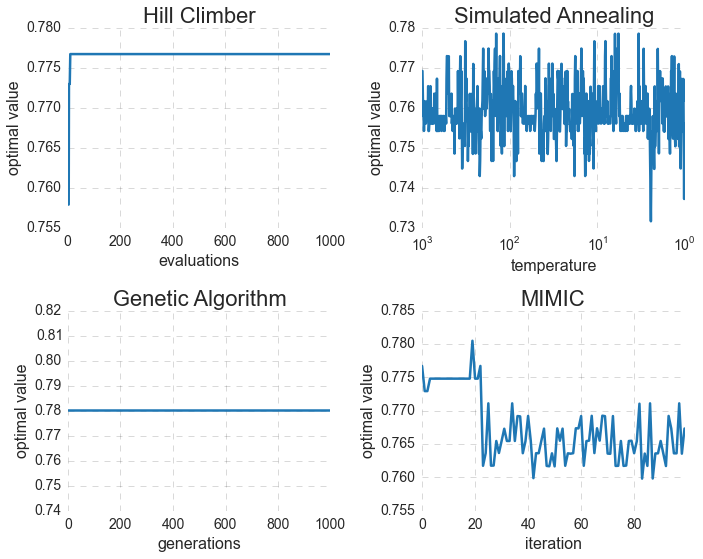

In [15]:
plt.plot_optimal_values(rhc_2_df, sa_2_df, ga_2_df, mm_2_df)

Needless to say, all four algorithms outperformed the baseline of 73% by increasing the accuracy to 78%. 

## Optimization Problem 3: Crontab job schedule optimization

Thinking about optimization problems gave me an idea on how to solve an existing problem in our work group where we have multiple cluster jobs competing for resources. Each job has an entry which is added to the crontab schedule on the master machine manually. This of course brings inefficiency in job executions:

* multiple jobs launching at the same time (preference seems to be the morning hours)
* there is idle time on the cluster where no jobs are running
* multiple jobs require a connection to reporting warehouse to collect data which means performance of the queries will suffer if too many requests come at the same time

For the purpose of this example, I created a binary random matrix:

* at the index is job id
* at the column is resource id
* value in the matrix equals 1 if specified job required specified resource and 0 otherwise
* additional column of current running time is added to aid the algorithm in finding the best possible schedule.

__Fitness Function__: max{(distance between jobs) / penalty (total overlap of resource)} or it's dual __Cost Function__: min{(overlap between jobs) * penalty (total overlap of resource)}

In [6]:
from algo_evaluation.optimization.problems import cronjob_schedule

Example of the scheduling problem presentation:

In [56]:
schedule_problem = cronjob_schedule.CronSchedule(n_jobs=100, n_resources=5, names=True)
schedule_problem.cron_tasks_df.head()

,resource_0,resource_1,resource_2,resource_3,resource_4,time
job_0,1,1,1,1,1,80
job_1,1,0,0,1,1,18
job_2,1,1,1,0,0,8
job_3,1,0,1,1,0,49
job_4,0,0,0,0,1,88


Domain is created with the list of pair tuples: first is the range of hour when to start the job (0..23) and second is the range of minutes (0..59). So solution will be a list of optimized start times per job.
To make it more interesting, the toy problem was extended to a larger number of jobs and resources.

In [8]:
rhc_3_df, sa_3_df, ga_3_df, mm_3_df = cronjob_schedule.compare_all()

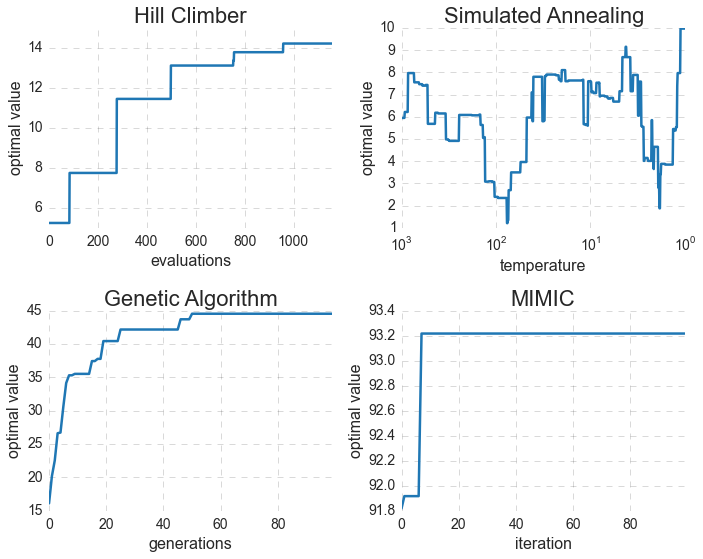

In [12]:
plt.plot_optimal_values(rhc_3_df, sa_3_df, ga_3_df, mm_3_df)

Both Hill Climber and Simulated Annealing got stuck at local optima since neither of them reached the best possible combination within 1000 iterations. It looks like __Hill climber__ is slowly 'climbing' in the solution space each time improving the optimal solution. For this specific problem it would be very easy for Hill Climber to get stuck as I have granularity of minutes in the solution. This could probably be improved if I use buckets of minutes (15, 30, 45) instead of the whole range (0..59)

__Simulated Annealing__ was trying better and worse solutions as is obvious from the graph, however it also got stuck at the local optima (note the X axis (Temperature) scale is again logarithmic to visualize the change better near low temperatures)

__Genetic Algorithm__ performed very well as it found very good solutions at the beginning of iterations. I find this very curious how it jump-started with a solution better than either Hill Climbing or Simulated Annealing could find with multiple iterations. Note two more "steps" in the curve of genetic algorithm - each one smaller than the previous - which suggest the conversion to the optimum.

__MIMIC__ was able to find the best solution for scheduling with the smallest number of iterations and in situations when time is not a constraint, the preference falls on this algorithm. Since creating a schedule for running jobs can be done once, it makes sense to relax time constraint in the favor of best solution.

## Conclusion

### Algorithm Clock Time Comparison

MIMIC is considerably the slowest algorithm and thus should be applied only when time is not a constraint (building Bayes net seems to be very expensive especially for large sample sizes and extensive number of iterations). Current experiments were performed with fixed number of iterations so for more fair clock-time analysis I could have selected convergence time instead. It is important to note that for the Classifier Optimization problem, MIMIC outperformed Genetic Algorithm time-wise. Clock-time for Hill Climber and Simulated Annealing were significantly smaller, which, given algorithm simplicity, makes sense.

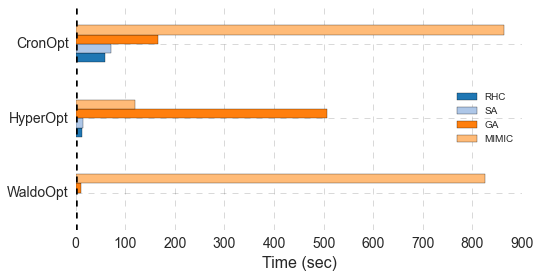

In [47]:
experiment_results = [[rhc_df, sa_df, ga_df, mm_df], 
                     [rhc_2_df, sa_2_df, ga_2_df, mm_2_df],
                     [rhc_3_df, sa_3_df, ga_3_df, mm_3_df]]
clock_times = plt.collect_and_plot_clocktimes(experiment_results)

### No Free Lunch

Based on the selected optimization problems, it is obvious that there is no clear cut answer when it comes to choosing the best algorithm. Algorithms performed differently for each of the problems, and depending on the requirement of the problem, trade-offs could be made toward either accuracy or speed. That being said, I still favored the Genetic Algorithm due to its steady evolution and overall better performance across different domain problems.
In addition to the optimal value dynamics analysis, it could have been useful to visualize the solutions of each problem as well, however due to space constraint they were not included.

In retrospect, I would have chosen simpler and smaller domain problems to have a lot quicker turnaround per experiment, however the chosen problems really helped me get a sense of what to expect from each algorithm, and I was able to successfully apply them to improve current infrastructure in my professional group (balancing cluster jobs) and rapid experimentation tuning (classifier optimization).

## References

1. Pybrain Optimization Documentation, Online Available, at http://pybrain.org/docs/tutorial/optimization.html

2. MIMIC: Finding Optima by Estimating Probability Densities,  http://www.cc.gatech.edu/~isbell/papers/isbell-mimic-nips-1997.pdf

3. DataElixir (Issue21) http://dataelixir.com/issues/21 (Here’s Waldo: Computing the optimal search strategy for finding Waldo)

4. Hyperopt-Sklearn: Automatic Hyperparameter Configuration for Scikit-Learn http://conference.scipy.org/proceedings/scipy2014/pdfs/komer.pdf

5. MIMIC Randomized Optimization Algorithm by M. Simpson, J. McGehee https://pypi.python.org/pypi/mimicry/0.2.0